In [19]:
%load_ext autoreload
%autoreload 2

import sys

import open3d as o3d
import matplotlib.pyplot as plt
import torch
import h5py

import copy 
import pycolmap

from pathlib import Path
import numpy as np

sys.path.append('/workspace/sk3d/dev.sk_robot_rgbd_data/src')
sys.path.append("/workspace/pixel-perfect-sfm/")
sys.path.append("/workspace/pixel-perfect-sfm/Hierarchical-Localization")

from hloc import extract_features, match_features, reconstruction, pairs_from_exhaustive, visualization
from hloc.visualization import plot_images, read_image
from hloc.utils.viz_3d import init_figure, plot_points, plot_reconstruction, plot_camera_colmap
from hloc.utils.read_write_model import  write_next_bytes, Point3D, Image, read_images_text, \
        read_points3D_binary, write_points3D_binary, write_images_binary, read_images_binary, \
        read_cameras_text

from skrgbd.data.io import imgio
from skrgbd.calibration.camera_models import load_colmap_camera
from skrgbd.data.io.poses import load_poses

from skrgbd.data.processing.depth_utils.occluded_mesh_rendering import MeshRenderer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "all"
print(os.environ["CUDA_VISIBLE_DEVICES"])

import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

all
1.11.0+cu113


In [3]:
scene_name = 'dragon'
delete_previous_output = True

has_cache = True
show_visualization = False

In [4]:
root =  Path('/workspace')

#poses
poses = root / f'datasets/sk3d/dataset/{scene_name}/tis_right/rgb/images.txt'

#cam_model
camera_model = root / 'datasets/sk3d/dataset/calibration/tis_right/rgb/cameras.txt'

images = root / f'datasets/sk3d/dataset/{scene_name}/tis_right/rgb/undistorted/ambient@best'
outputs = root / f'pixel-perfect-sfm/outputs/{scene_name}/experiment_5'

if delete_previous_output:
    !rm -rf $outputs 
    
outputs.mkdir(parents=True, exist_ok=True)  

if has_cache:
    cache_init = root / f'pixel-perfect-sfm/outputs/caches/{scene_name}/s2dnet_featuremaps_sparse.h5'
    !cp -r $cache_init $outputs
    cache_path = outputs / 's2dnet_featuremaps_sparse.h5'  

sfm_pairs = outputs / 'pairs-sfm.txt'
features = outputs / 'features.h5'
refined_keypoints = outputs / 'refined_keypoints.h5'
matches = outputs / 'matches.h5'


!cp -r /workspace/pixel-perfect-sfm/outputs/dragon/features.h5 $outputs
!cp -r /workspace/pixel-perfect-sfm/outputs/dragon/matches.h5 $outputs
!cp -r /workspace/pixel-perfect-sfm/outputs/dragon/pairs-sfm.txt $outputs
!cp -r /workspace/pixel-perfect-sfm/outputs/dragon/ref_exp2/refined_keypoints.h5 $outputs

!ls $outputs

features.h5  pairs-sfm.txt	   s2dnet_featuremaps_sparse.h5
matches.h5   refined_keypoints.h5


In [5]:
exp5_dir = outputs / 'base'
exp5_dir.mkdir(parents=True, exist_ok=True)

!cp -r $poses $exp5_dir
!cp -r $camera_model $exp5_dir
!touch $exp5_dir/points3D.txt

!ls $exp5_dir

cameras.txt  images.txt  points3D.txt


In [6]:
reconstruction = pycolmap.Reconstruction(exp5_dir)
print(reconstruction.summary())

Reconstruction:
	num_reg_images = 100
	num_cameras = 1
	num_points3D = 0
	num_observations = 0
	mean_track_length = 0
	mean_observations_per_image = 0
	mean_reprojection_error = 0


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3060
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [69]:
from hloc.utils.io import get_matches

matches_copy = '/workspace/tmp/matches.h5'
        
name0, name1 = '0001.png', '0002.png'    
matches, scores = get_matches(matches_copy, name0, name1)
    
print(matches)

[[  0   0]
 [  1   4]
 [  2   2]
 [  3   3]
 [  7  14]
 [  9   7]
 [ 10   8]
 [ 11  12]
 [ 12   9]
 [ 14  10]
 [ 15  11]
 [ 16  15]
 [ 17   6]
 [ 18  16]
 [ 19  17]
 [ 21  21]
 [ 22  19]
 [ 24  22]
 [ 25  23]
 [ 26  20]
 [ 27  24]
 [ 28  25]
 [ 29  26]
 [ 31  31]
 [ 33  32]
 [ 34  30]
 [ 35  28]
 [ 36  29]
 [ 39  34]
 [ 40  33]
 [ 41  36]
 [ 42  40]
 [ 43  37]
 [ 45  38]
 [ 46  42]
 [ 48  39]
 [ 50  44]
 [ 51  41]
 [ 52  48]
 [ 54  52]
 [ 55  54]
 [ 59  46]
 [ 60  57]
 [ 61  58]
 [ 62  53]
 [ 63  50]
 [ 64  56]
 [ 65  64]
 [ 66  59]
 [ 67  62]
 [ 69  69]
 [ 70  74]
 [ 72  67]
 [ 73  61]
 [ 74  71]
 [ 76  75]
 [ 77  70]
 [ 78  72]
 [ 79  76]
 [ 80  73]
 [ 81  83]
 [ 82  79]
 [ 83  81]
 [ 86  84]
 [ 87  80]
 [ 88  78]
 [ 89  87]
 [ 90  85]
 [ 91  91]
 [ 92  82]
 [ 93  93]
 [ 94  94]
 [ 95  92]
 [ 96  89]
 [ 97 100]
 [ 98  97]
 [ 99 102]
 [100  90]
 [101  96]
 [102  86]
 [103 103]
 [106 107]
 [107 109]
 [108 104]
 [109  98]
 [110 108]
 [113 110]
 [114  99]
 [116 116]
 [117 118]
 [118 113]

In [8]:
from hloc.utils.io import get_keypoints

image_ids = {image.name: i for i, image in reconstruction.images.items()}  
    
keypoints_dict = {}    
for image_name, image_id in image_ids.items():
    keypoints_dict[image_id] = get_keypoints(refined_keypoints, image_name) + 0.5  # COLMAP origin

Define 2D keypoints.
A keypoint at the upper left corner of the upper left pixel would have coords `(0, 0)`, and
a keypoint at the lower right corner of the lower right pixel would have coords `(width, height)`.

In [9]:
print(keypoints_dict[1], len(keypoints_dict[1]))

keypoints = keypoints_dict[1]

[[1705.48963777  167.64322579]
 [ 121.19210141  367.64892313]
 [1116.65532248  383.11528527]
 ...
 [2128.81402075 1906.16305184]
 [ 685.5        1913.5       ]
 [1761.49605035 1914.97095782]] 551


Load data: scan, camera model, camera poses.

In [10]:
sk3d_root = '/workspace/datasets/sk3d'

dtype = torch.float
device = 'cpu'

rec = f'{sk3d_root}/dataset/{scene_name}/stl/reconstruction/cleaned.ply'
rec = o3d.io.read_triangle_mesh(rec)

occ = f'{sk3d_root}/dataset/{scene_name}/stl/occluded_space.ply'
occ = o3d.io.read_triangle_mesh(occ)

renderer = MeshRenderer(rec, occ); del occ

cam_model = f'{sk3d_root}/dataset/calibration/tis_right/rgb/cameras.txt'
cam_model = load_colmap_camera(cam_model).to(device, dtype)

poses = f'{sk3d_root}/dataset/{scene_name}/tis_right/rgb/images.txt'
world_to_cam = load_poses(poses, dtype).to(device, dtype)

tensor([[1705.4896,  167.6432],
        [ 121.1921,  367.6489],
        [1116.6553,  383.1153],
        ...,
        [2128.8140, 1906.1631],
        [ 685.5000, 1913.5000],
        [1761.4961, 1914.9709]], dtype=torch.float32)


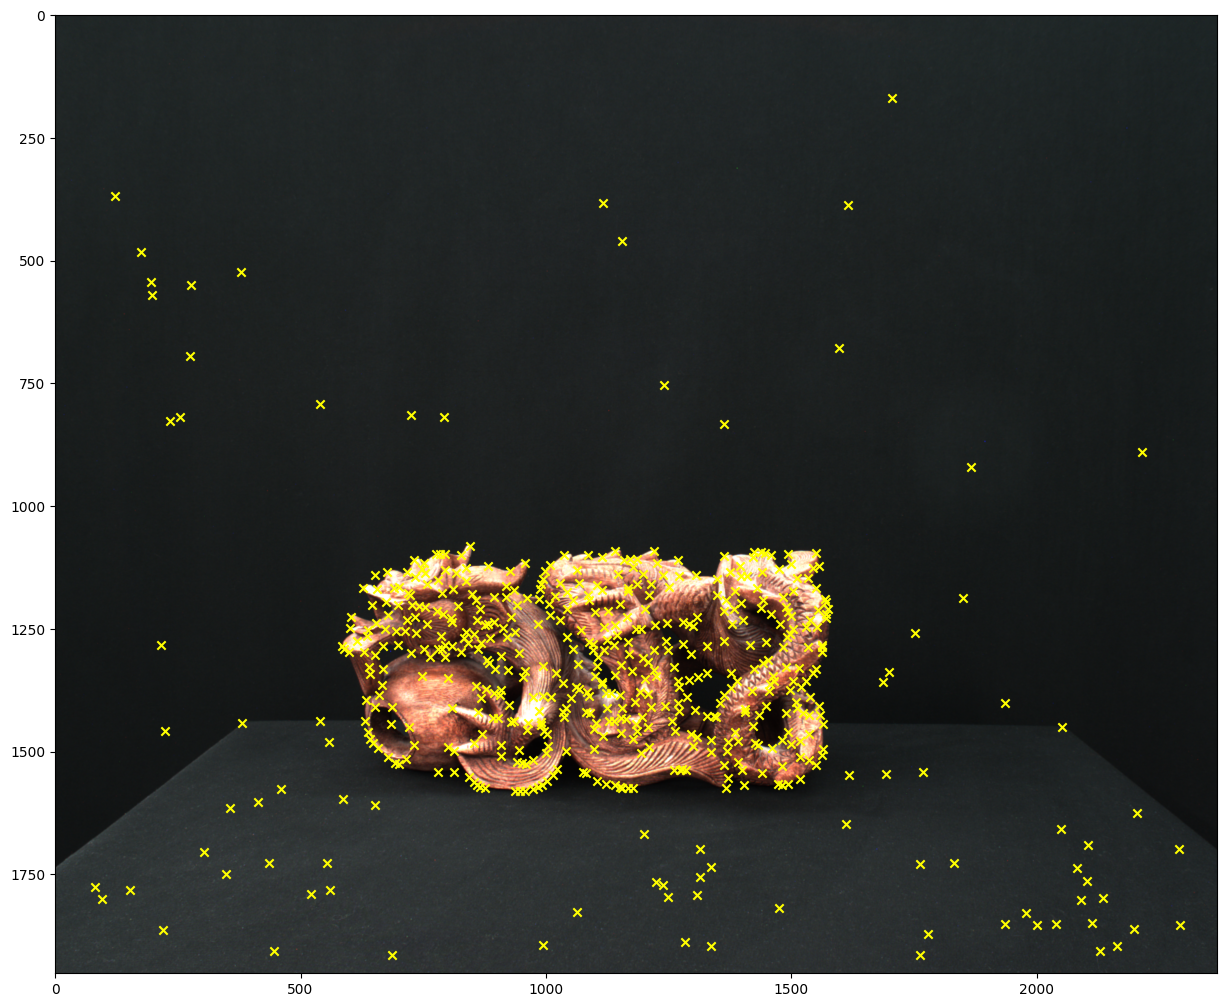

In [11]:
view_i = 0

key_pts = torch.tensor(keypoints, dtype=dtype)  # [[x1, y1], [x2, y2], ...]

# Visualize keypoints
img = f'{sk3d_root}/dataset/{scene_name}/tis_right/rgb/undistorted/ambient@best/{view_i:04}.png'
img = imgio.read.tis_right.rgb(img)

plt.figure(figsize=[15]*2)
plt.imshow(img)

print(key_pts)

plt.scatter(key_pts[:, 0], key_pts[:, 1], marker='x', c='yellow')

Trace rays.

In [12]:
ray_dirs_in_cam_space = cam_model.unproject(key_pts.T.to(device, dtype))  # shape is 3, pts_n
pts_n = ray_dirs_in_cam_space.shape[1]

cam_to_world = world_to_cam[view_i].inverse()  # 4, 4
cam_center_in_world_space = cam_to_world[:3, 3]  # 3
ray_origins_in_world_space = cam_center_in_world_space.unsqueeze(0).expand(pts_n, -1)  # pts_n, 3
cam_to_world_rot = cam_to_world[:3, :3]
ray_dirs_in_world_space = ray_dirs_in_cam_space.T @ cam_to_world_rot.T  # pts_n, 3

casted_rays = torch.cat([ray_origins_in_world_space, ray_dirs_in_world_space], 1)  # pts_n, 6
renderer.occ_threshold = 1e-3

hit_depth = renderer.render_rays(casted_rays, cull_back_faces=True)['ray_hit_depth']
print(hit_depth)
print(hit_depth.shape)

tensor([   inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,
           inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,
           inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,
           inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf, 0.7766,
           inf,    inf, 0.7569, 0.7657,    inf,    inf, 0.7716,    inf, 0.7643,
           inf,    inf,    inf, 0.7564,    inf, 0.7441,    inf, 0.7404, 0.7556,
        0.7457,    inf, 0.7538, 0.7179, 0.7522, 0.7112,    inf,    inf, 0.7171,
           inf, 0.7258, 0.7456,    inf,    inf, 0.7511, 0.7507, 0.7415, 0.7366,
        0.7276, 0.7347, 0.6910,    inf,    inf, 0.7153, 0.7275, 0.7765,    inf,
        0.7088, 0.6921, 0.6882, 0.7444,    inf, 0.6861, 0.7260, 0.7502, 0.7113,
           inf, 0.7174, 0.7332,    inf, 0.7347, 0.7202, 0.7088,    inf,    inf,
        0.6861, 0.7112, 0.6841, 0.7178, 0.6825, 0.7090, 0.7152, 0.6884, 0.7109,
        0.7101, 0.6829, 0.7448, 0.7087, 

Keep only keypoints with a finite hit depth.

In [13]:
print((ray_dirs_in_world_space * hit_depth.unsqueeze(1) +  ray_origins_in_world_space)[35])

tensor([-0.0553, -0.0654,  0.7734], dtype=torch.float32)


In [14]:
did_hit = hit_depth.isfinite()
pts_3d = (ray_dirs_in_world_space * hit_depth.unsqueeze(1) + ray_origins_in_world_space)[did_hit]
print(pts_3d)

tensor([[-5.5297e-02, -6.5447e-02,  7.7342e-01],
        [ 1.3702e-01, -6.7893e-02,  7.3693e-01],
        [ 6.2424e-02, -6.4061e-02,  7.5790e-01],
        [ 5.4263e-02, -6.2751e-02,  7.6461e-01],
        [ 7.5693e-02, -6.1825e-02,  7.5457e-01],
        [ 1.6120e-01, -6.3292e-02,  7.3009e-01],
        [ 1.2622e-01, -6.3004e-02,  7.2554e-01],
        [-5.0349e-02, -6.1716e-02,  7.3666e-01],
        [ 5.8375e-02, -5.9940e-02,  7.4767e-01],
        [-7.8812e-02, -6.0705e-02,  7.4034e-01],
        [-6.4540e-02, -5.8897e-02,  7.4926e-01],
        [ 1.9103e-02, -6.2417e-02,  7.1325e-01],
        [ 1.5283e-01, -6.0736e-02,  7.2751e-01],
        [-5.5976e-02, -6.1818e-02,  7.0706e-01],
        [ 1.3400e-01, -6.3053e-02,  6.9591e-01],
        [ 1.1611e-01, -6.1085e-02,  7.0850e-01],
        [-7.7016e-02, -5.7835e-02,  7.4003e-01],
        [ 4.8337e-02, -5.6215e-02,  7.4363e-01],
        [ 6.4241e-02, -5.5847e-02,  7.4153e-01],
        [ 7.6113e-02, -5.6510e-02,  7.3068e-01],
        [ 8.5938e-02

Save and check.

In [15]:
pc = o3d.geometry.PointCloud()
pc.points.extend(pts_3d.double().numpy())

o3d.io.write_point_cloud(str(outputs / 'pts.ply'), pc)
o3d.io.write_triangle_mesh(str(outputs / 'scan.ply'), rec)

True

In [ ]:
# https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.remove_edge.html
# https://www.idtools.com.au/3d-network-graphs-with-python-and-the-mplot3d-toolkit/


In [16]:
try:
    import hloc
except ImportError:
    print("Could not import hloc.")
    hloc = None

In [70]:
hloc_path = exp5_dir / 'hloc'
hloc_path.mkdir(parents=True, exist_ok=True)

database_path = hloc_path / 'database.db' 
reference = pycolmap.Reconstruction(exp5_dir)   

images_txt_path = exp5_dir / 'images.txt'
images_dict = read_images_text(images_txt_path)
        
# Here I changed code and in database we have data about camera extrinsics    
image_ids = hloc.triangulation.create_db_from_model(reference, 
                                                    database_path, 
                                                    images_dict)
print(image_ids)

#Importing features into database -> keypoints table 
hloc.triangulation.import_features(image_ids, 
                                   database_path, 
                                   refined_keypoints)

#Importing matches into database -> matches table
hloc.triangulation.import_matches(image_ids, 
                                  database_path, 
                                  sfm_pairs, 
                                  matches,
                                  min_match_score=None, 
                                  skip_geometric_verification=False)

[2022/11/05 09:00:37 hloc WARNING] The database already exists, deleting it.
[2022/11/05 09:00:38 hloc INFO] Images info from images dictionary.
[2022/11/05 09:00:38 hloc INFO] Importing features into the database...


{'0000.png': 1, '0001.png': 2, '0002.png': 3, '0003.png': 4, '0004.png': 5, '0005.png': 6, '0006.png': 7, '0007.png': 8, '0008.png': 9, '0009.png': 10, '0010.png': 11, '0011.png': 12, '0012.png': 13, '0013.png': 14, '0014.png': 15, '0015.png': 16, '0016.png': 17, '0017.png': 18, '0018.png': 19, '0019.png': 20, '0020.png': 21, '0021.png': 22, '0022.png': 23, '0023.png': 24, '0024.png': 25, '0025.png': 26, '0026.png': 27, '0027.png': 28, '0028.png': 29, '0029.png': 30, '0030.png': 31, '0031.png': 32, '0032.png': 33, '0033.png': 34, '0034.png': 35, '0035.png': 36, '0036.png': 37, '0037.png': 38, '0038.png': 39, '0039.png': 40, '0040.png': 41, '0041.png': 42, '0042.png': 43, '0043.png': 44, '0044.png': 45, '0045.png': 46, '0046.png': 47, '0047.png': 48, '0048.png': 49, '0049.png': 50, '0050.png': 51, '0051.png': 52, '0052.png': 53, '0053.png': 54, '0054.png': 55, '0055.png': 56, '0056.png': 57, '0057.png': 58, '0058.png': 59, '0059.png': 60, '0060.png': 61, '0061.png': 62, '0062.png': 63, 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 972.93it/s]
[2022/11/05 09:00:38 hloc INFO] Importing matches into the database...
  0%|                                                                                                                  | 0/4950 [00:00<?, ?it/s]


OSError: [Errno 36] Unable to open file (unable to open file: name = '[[  0   0]
 [  1   4]
 [  2   2]
 [  3   3]
 [  7  14]
 [  9   7]
 [ 10   8]
 [ 11  12]
 [ 12   9]
 [ 14  10]
 [ 15  11]
 [ 16  15]
 [ 17   6]
 [ 18  16]
 [ 19  17]
 [ 21  21]
 [ 22  19]
 [ 24  22]
 [ 25  23]
 [ 26  20]
 [ 27  24]
 [ 28  25]
 [ 29  26]
 [ 31  31]
 [ 33  32]
 [ 34  30]
 [ 35  28]
 [ 36  29]
 [ 39  34]
 [ 40  33]
 [ 41  36]
 [ 42  40]
 [ 43  37]
 [ 45  38]
 [ 46  42]
 [ 48  39]
 [ 50  44]
 [ 51  41]
 [ 52  48]
 [ 54  52]
 [ 55  54]
 [ 59  46]
 [ 60  57]
 [ 61  58]
 [ 62  53]
 [ 63  50]
 [ 64  56]
 [ 65  64]
 [ 66  59]
 [ 67  62]
 [ 69  69]
 [ 70  74]
 [ 72  67]
 [ 73  61]
 [ 74  71]
 [ 76  75]
 [ 77  70]
 [ 78  72]
 [ 79  76]
 [ 80  73]
 [ 81  83]
 [ 82  79]
 [ 83  81]
 [ 86  84]
 [ 87  80]
 [ 88  78]
 [ 89  87]
 [ 90  85]
 [ 91  91]
 [ 92  82]
 [ 93  93]
 [ 94  94]
 [ 95  92]
 [ 96  89]
 [ 97 100]
 [ 98  97]
 [ 99 102]
 [100  90]
 [101  96]
 [102  86]
 [103 103]
 [106 107]
 [107 109]
 [108 104]
 [109  98]
 [110 108]
 [113 110]
 [114  99]
 [116 116]
 [117 118]
 [118 113]
 [119 114]
 [120 119]
 [121 120]
 [123 123]
 [124 127]
 [125 133]
 [126 131]
 [127 126]
 [128 125]
 [129 134]
 [132 140]
 [133 141]
 [135 137]
 [136 135]
 [137 128]
 [138 129]
 [139 130]
 [140 142]
 [141 148]
 [142 143]
 [144 149]
 [145 147]
 [146 144]
 [147 139]
 [148 154]
 [149 146]
 [151 152]
 [152 162]
 [153 166]
 [154 167]
 [156 163]
 [157 157]
 [159 156]
 [160 170]
 [161 164]
 [162 158]
 [163 168]
 [164 159]
 [165 160]
 [166 153]
 [168 165]
 [170 161]
 [171 179]
 [172 176]
 [173 175]
 [174 181]
 [175 177]
 [176 169]
 [177 172]
 [179 180]
 [182 173]
 [183 182]
 [187 188]
 [188 189]
 [189 193]
 [190 194]
 [192 183]
 [194 195]
 [195 196]
 [196 197]
 [197 198]
 [198 204]
 [199 192]
 [200 187]
 [201 211]
 [202 203]
 [203 209]
 [205 191]
 [206 208]
 [208 206]
 [210 207]
 [212 202]
 [214 201]
 [215 215]
 [216 218]
 [217 216]
 [218 213]
 [221 217]
 [222 227]
 [223 224]
 [224 232]
 [225 234]
 [227 220]
 [228 226]
 [230 222]
 [231 235]
 [232 236]
 [233 225]
 [234 242]
 [235 230]
 [236 241]
 [237 237]
 [238 243]
 [239 238]
 [240 239]
 [241 231]
 [242 246]
 [244 249]
 [245 252]
 [247 240]
 [248 255]
 [249 248]
 [251 245]
 [252 253]
 [253 251]
 [254 244]
 [255 256]
 [256 257]
 [257 250]
 [258 262]
 [259 259]
 [261 258]
 [262 254]
 [264 263]
 [265 264]
 [266 265]
 [268 260]
 [269 271]
 [271 266]
 [272 267]
 [273 273]
 [274 275]
 [275 269]
 [276 270]
 [278 276]
 [279 268]
 [282 280]
 [283 281]
 [284 274]
 [288 290]
 [289 285]
 [291 284]
 [293 282]
 [294 288]
 [295 295]
 [297 304]
 [298 291]
 [300 293]
 [301 305]
 [303 300]
 [304 301]
 [305 302]
 [307 296]
 [308 303]
 [309 297]
 [310 294]
 [313 308]
 [314 292]
 [315 312]
 [316 311]
 [317 306]
 [318 314]
 [319 310]
 [320 327]
 [321 309]
 [322 332]
 [323 320]
 [324 317]
 [326 316]
 [327 334]
 [328 322]
 [329 315]
 [332 328]
 [333 321]
 [334 333]
 [335 323]
 [336 324]
 [338 325]
 [340 326]
 [341 344]
 [342 341]
 [343 336]
 [344 343]
 [345 347]
 [346 349]
 [348 340]
 [349 337]
 [350 338]
 [351 348]
 [352 342]
 [353 331]
 [354 350]
 [355 351]
 [357 352]
 [358 357]
 [360 358]
 [361 353]
 [362 362]
 [363 345]
 [364 363]
 [365 361]
 [367 354]
 [369 369]
 [370 367]
 [371 365]
 [372 360]
 [374 382]
 [375 376]
 [377 368]
 [378 371]
 [379 370]
 [380 383]
 [381 381]
 [382 366]
 [383 394]
 [386 373]
 [387 377]
 [388 396]
 [389 380]
 [390 375]
 [392 391]
 [393 372]
 [394 390]
 [395 387]
 [396 385]
 [397 395]
 [399 378]
 [402 388]
 [404 406]
 [405 417]
 [406 405]
 [407 393]
 [408 392]
 [409 407]
 [411 403]
 [412 399]
 [413 414]
 [414 410]
 [415 408]
 [416 426]
 [417 418]
 [418 411]
 [419 415]
 [420 423]
 [421 424]
 [422 419]
 [423 412]
 [424 409]
 [425 428]
 [426 413]
 [427 420]
 [428 416]
 [429 434]
 [430 430]
 [431 425]
 [432 421]
 [433 443]
 [434 422]
 [435 439]
 [436 442]
 [438 436]
 [439 440]
 [440 437]
 [441 441]
 [442 435]
 [443 438]
 [444 431]
 [445 451]
 [447 447]
 [448 433]
 [449 448]
 [450 449]
 [451 446]
 [452 444]
 [453 458]
 [454 459]
 [455 453]
 [456 457]
 [457 460]
 [458 454]
 [459 452]
 [460 461]
 [461 455]
 [462 456]
 [463 469]
 [464 463]
 [465 466]
 [466 462]
 [467 467]
 [468 468]
 [471 471]
 [472 472]
 [473 470]
 [474 474]
 [475 473]
 [476 476]
 [477 465]
 [479 478]
 [480 479]
 [482 475]
 [483 477]
 [484 485]
 [485 481]
 [486 480]
 [488 483]
 [489 491]
 [490 487]
 [491 486]
 [492 490]
 [493 505]
 [494 500]
 [495 496]
 [496 498]
 [497 492]
 [499 499]
 [500 497]
 [501 513]
 [503 503]
 [505 506]
 [507 502]
 [508 511]
 [511 519]
 [512 508]
 [513 504]
 [514 512]
 [515 510]
 [516 509]
 [517 520]
 [518 517]
 [519 521]
 [521 516]
 [523 518]
 [524 524]
 [526 525]
 [527 522]
 [528 529]
 [529 526]
 [530 530]]', errno = 36, error message = 'File name too long', flags = 0, o_flags = 0)

In [21]:
from pixsfm.util.colmap import (
    read_keypoints_from_db, read_matches_from_db, write_keypoints_to_db)

keypoints = read_keypoints_from_db(database_path)
pairs, matches, scores = read_matches_from_db(database_path)

In [22]:
from pixsfm.keypoint_adjustment import build_matching_graph
from pixsfm import base, features, logger

matches_scores = (matches, scores)
graph = build_matching_graph(pairs, *matches_scores)
print(graph)

[2022/11/05 03:58:16 pixsfm INFO] Building matching graph...


I compute track labels to see how many graph nodes, grap edges, tracks I have. Each track has its own index, here we have 1310 tracks,

In [71]:
track_labels = base.compute_track_labels(graph)
print(len(track_labels))

[2022/11/05 09:37:15 pixsfm INFO] Computing tracks...
49802
[2022/11/05 09:37:15 pixsfm INFO] # graph nodes: 49802
[2022/11/05 09:37:15 pixsfm INFO] # graph edges: 1376794
[2022/11/05 09:37:18 pixsfm INFO] # tracks: 1310


In [73]:
print(max(track_labels))

1309


In [65]:
# 49802 nodes
# A graph nodes is a vector, so I can access there via [].
# A node has node_idx, image_id, feature_idx, num_matches, out_mathces
# A graph node out matches is a vector, so I can access there via [].

for i in range(5):
    print(graph.nodes[i])
    print(graph.nodes[i].out_matches[0])
    print()

<FeatureNode <node_idx=0, image_id=0, feature_idx=0, num_matches=15>
<Match <node_idx=1, similarity=1>

<FeatureNode <node_idx=1, image_id=1, feature_idx=17, num_matches=6>
<Match <node_idx=848, similarity=1>

<FeatureNode <node_idx=2, image_id=0, feature_idx=1, num_matches=20>
<Match <node_idx=3, similarity=1>

<FeatureNode <node_idx=3, image_id=1, feature_idx=1, num_matches=30>
<Match <node_idx=845, similarity=1>

<FeatureNode <node_idx=4, image_id=0, feature_idx=2, num_matches=24>
<Match <node_idx=5, similarity=1>



In [43]:
# A edge has (node1, node2, similarity)

graph.edges()

[(0, 1, 1.0),
 (0, 844, 1.0),
 (0, 6927, 1.0),
 (0, 7315, 1.0),
 (0, 12741, 1.0),
 (0, 18089, 1.0),
 (0, 18899, 1.0),
 (0, 19917, 1.0),
 (0, 21274, 1.0),
 (0, 21316, 1.0),
 (0, 21349, 1.0),
 (0, 22848, 1.0),
 (0, 23082, 1.0),
 (0, 23324, 1.0),
 (0, 24961, 1.0),
 (1, 848, 1.0),
 (1, 27624, 1.0),
 (1, 27670, 1.0),
 (1, 18904, 1.0),
 (1, 19917, 1.0),
 (1, 29447, 1.0),
 (2, 3, 1.0),
 (2, 845, 1.0),
 (2, 1266, 1.0),
 (2, 6928, 1.0),
 (2, 8035, 1.0),
 (2, 10447, 1.0),
 (2, 14022, 1.0),
 (2, 15415, 1.0),
 (2, 15668, 1.0),
 (2, 17830, 1.0),
 (2, 18613, 1.0),
 (2, 18898, 1.0),
 (2, 19171, 1.0),
 (2, 21312, 1.0),
 (2, 21350, 1.0),
 (2, 21463, 1.0),
 (2, 22849, 1.0),
 (2, 23083, 1.0),
 (2, 23325, 1.0),
 (2, 24962, 1.0),
 (3, 845, 1.0),
 (3, 1266, 1.0),
 (3, 25193, 1.0),
 (3, 25360, 1.0),
 (3, 25587, 1.0),
 (3, 5780, 1.0),
 (3, 6928, 1.0),
 (3, 7320, 1.0),
 (3, 10842, 1.0),
 (3, 27472, 1.0),
 (3, 27514, 1.0),
 (3, 27728, 1.0),
 (3, 27785, 1.0),
 (3, 15668, 1.0),
 (3, 16310, 1.0),
 (3, 28342, 1.0),

In [47]:
graph.degrees()

Vector_SizeT[15, 7, 20, 31, 24, 19, 10, 8, 18, 21, 9, 11, 42, 35, 19, 26, 33, 21, 22, 22, 29, 27, 15, 17, 58, 32, 97, 96, 92, 91, 91, 92, 69, 68, 33, 21, 34, 54, 91, 93, 15, 8, 50, 60, 92, 92, 67, 82, 60, 65, 77, 26, 91, 87, 33, 53, 89, 91, 55, 37, 80, 86, 58, 50, 60, 54, 36, 30, 83, 88, 33, 31, 19, 32, 78, 78, 49, 49, 79, 77, 71, 77, 60, 30, 90, 90, 68, 52, 43, 68, 71, 69, 50, 48, 50, 55, 88, 87, 50, 47, 85, 82, 89, 89, 73, 77, 81, 81, 46, 61, 85, 90, 26, 18, 69, 71, 62, 74, 45, 38, 98, 98, 99, 99, 55, 46, 43, 31, 98, 97, 71, 69, 15, 10, 28, 34, 53, 85, 80, 81, 93, 90, 95, 94, 61, 94, 96, 96, 89, 83, 78, 79, 68, 59, 44, 38, 71, 89, 55, 36, 97, 98, 15, 19, 96, 95, 97, 96, 73, 73, 64, 56, 55, 50, 51, 48, 99, 99, 25, 8, 46, 46, 71, 75, 76, 77, 71, 67, 35, 33, 63, 62, 20, 14, 12, 31, 67, 74, 74, 78, 77, 78, 95, 95, 51, 51, 90, 95, 57, 54, 69, 71, 97, 97, 14, 16, 2, 13, 51, 99, 14, 12, 54, 55, 89, 87, 23, 22, 59, 57, 60, 63, 66, 66, 18, 21, 87, 88, 28, 27, 31, 26, 43, 42, 91, 92, 57, 50, 1

In [ ]:
reconstruction = hloc.triangulation.run_triangulation(hloc_path, 
                                                      database_path, 
                                                      images, 
                                                      reference, 
                                                      verbose)

print(reconstruction.summary())  

# Saving result to a folder
reconstruction.write(str(hloc_path))

!mkdir -p $hloc_path/model_txt/

!colmap model_converter \
    --input_path $hloc_path \
    --output_path $hloc_path/model_txt/\
    --output_type TXT